<a href="https://colab.research.google.com/github/migostro/laboratorio-de-visao/blob/main/1_NormalizeDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# utilities
from operator import truediv
import os
import time
import numpy as np
from google.colab import files, drive

# image processing
from skimage import io, exposure

# visualization
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Helper Functions

In [ ]:
def float_to_int(img):
    return (img*255).astype(np.uint8)

In [ ]:
# list_filepaths(): list filepath for every filepath on a root folder
# pre-condition: (root path, empty list)
# post-condition: list with every filepath on root path
def list_filepaths(path, file_extension, filepaths = []):
    if os.path.isdir(path):
        for filename in os.listdir(path):
            filepath = os.path.join(path, filename)
            if os.path.isfile(filepath) and file_extension in filename: filepaths.append(filepath) # Adiciona apenas caminhos que são de arquivos (que no nosso caso são imagens)
            else: list_filepaths(filepath, file_extension, filepaths)

    return filepaths

In [ ]:
def get_averages(filepaths, classes):
    rr, cc = io.imread(filepaths[0]).shape
    averages = np.zeros((rr, cc, len(classes)), dtype=np.uint32)
    class_size = np.zeros(len(classes))

    for idx, filepath in enumerate(filepaths):
        print(idx)
        curr_class = filepath.split('/')[-3]
        class_index = np.where(classes == curr_class)[0] # get class idx
        if(len(class_index) > 0):
            img = io.imread(filepath)
            averages[:, :, class_index[0]] += img # sum img to class avg
            class_size[class_index[0]] += 1

    for idx in range(len(classes)):
        averages[:, :, idx] = averages[:, :, idx] / class_size[idx]

    return averages

In [ ]:
def calcula_media_classes(caminhos, classes):
  img = io.imread(caminhos[0])
  media_classes = []
  quantidade_imagens_por_classe = np.zeros([len(classes)])

  for classe in classes:
    media_classes.append(np.zeros(img.shape, dtype=np.uint32))


  for idx, caminho in enumerate(caminhos):
    for i in range(len(classes)): # encontra de qual classe é a imagem
      if classes[i] == caminho.split('/')[-3]:
        print(f'[{idx}]', caminho)
        imagem = io.imread(caminho)
        media_classes[i] += imagem # soma a imagem a classe correspondente
        quantidade_imagens_por_classe[i] += 1

        break

  for i in range(len(classes)):
    media_classes[i] = media_classes[i]/quantidade_imagens_por_classe[i]

  return media_classes

# Pipeline

In [ ]:
# 0 FILE READING
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/MAC0417/Trabalho/0_new'

originalData_path = root + '/originalDataSet'
grayData_path = root + '/originalGreyDataSet'
augumentedData_path = root + '/augmentedDataSet'
normalizedData_path = root + "/normalizedDataSet"

original_filepaths = list_filepaths(originalData_path, 'JPG', [])
gray_filepaths = list_filepaths(grayData_path, 'JPG', [])
augumented_filepaths = list_filepaths(augumentedData_path, 'JPG', [])
normalized_filepaths = list_filepaths(normalizedData_path, 'JPG', [])
print(f'# of images @ {originalData_path}: {len(original_filepaths)}')
print(f'# of images @ {grayData_path}: {len(gray_filepaths)}')
print(f'# of images @ {augumentedData_path}: {len(augumented_filepaths)}')
print(f'# of images @ {normalizedData_path}: {len(normalized_filepaths)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# of images @ /content/drive/MyDrive/Colab/MAC0417/Trabalho/0_new/originalDataSet: 1080
# of images @ /content/drive/MyDrive/Colab/MAC0417/Trabalho/0_new/originalGreyDataSet: 1080
# of images @ /content/drive/MyDrive/Colab/MAC0417/Trabalho/0_new/augmentedDataSet: 5400
# of images @ /content/drive/MyDrive/Colab/MAC0417/Trabalho/0_new/normalizedDataSet: 5400


In [ ]:
for img_path in normalized_filepaths:
    os.remove(img_path)

In [ ]:
# 1 GENERATE NORMALIZED IMAGES
for img_path in augumented_filepaths:
    img = io.imread(img_path)
    filename = img_path.split('/')[-1]

    # pastas que estão entre a originalDataSet e o arquivo (não incluindo nenhum dos dois)
    middle_path = img_path.replace(augumentedData_path, '').replace(filename, '')

    # Equaliza a imagem
    eq_img = exposure.equalize_hist(img)
    
    if not os.path.isdir(normalizedData_path + middle_path): os.makedirs(normalizedData_path + middle_path)
    io.imsave(img_path.replace(augumentedData_path, normalizedData_path), float_to_int(eq_img))

In [ ]:
# 2 EVALUATES CLASS VARIANCE
classes = np.array(['borrachas', 'cartas', 'celulares', 'conchas', 'copos', 'dados', 'estatuas', 'lapis', 'tubos', 'vasos'])

In [ ]:
augmented_avg =  calcula_media_classes(augumented_filepaths, classes)

In [ ]:
gray_avg =       calcula_media_classes(gray_filepaths, classes)

In [ ]:
normalized_avg = calcula_media_classes(normalized_filepaths, classes)

Baixa variância -> imagem homogênea (- variabilidade)
Alta variância -> imagem heterogênea (+ variabilidade)

[0] borrachas 



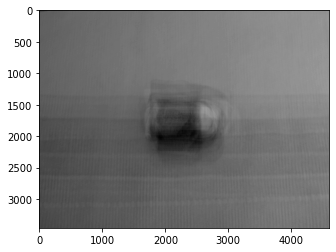

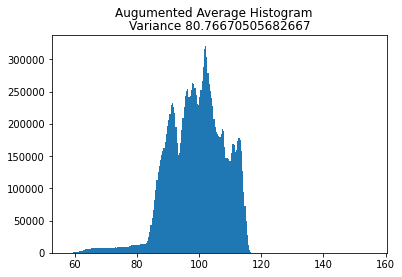




[1] cartas 



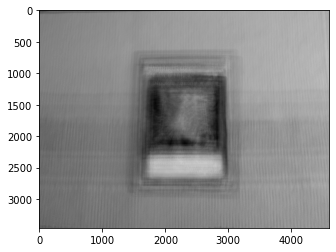

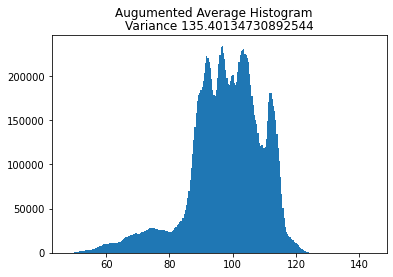




[2] celulares 



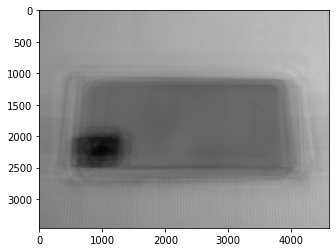

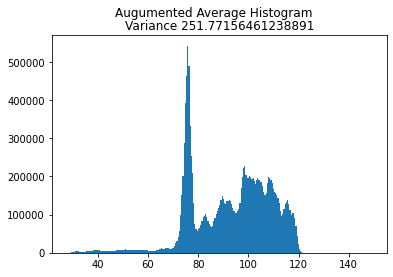




[3] conchas 



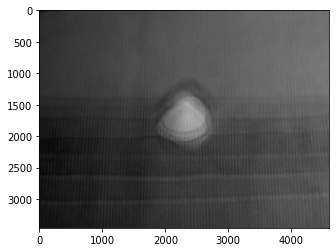

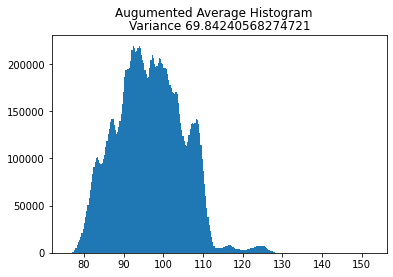




[4] copos 



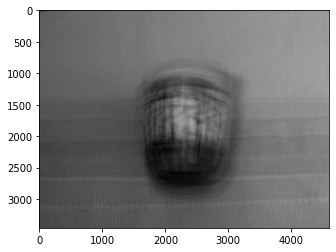

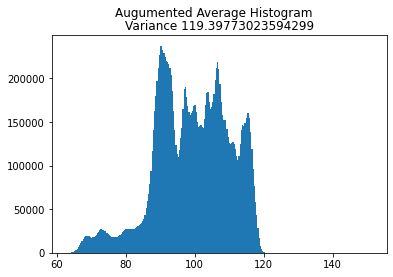




[5] dados 



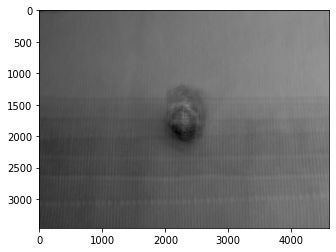

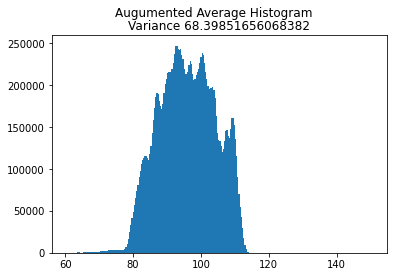




[6] estatuas 



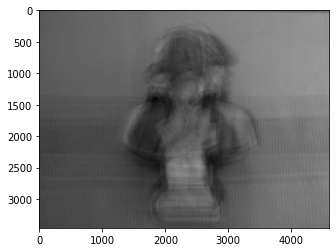

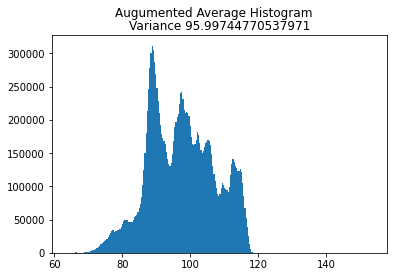




[7] lapis 



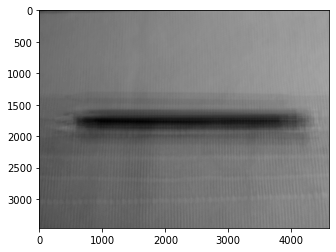

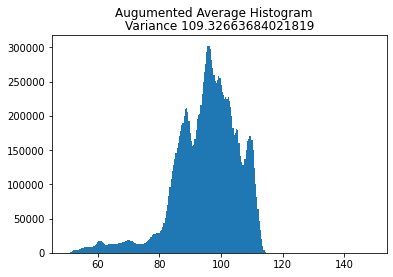




[8] tubos 



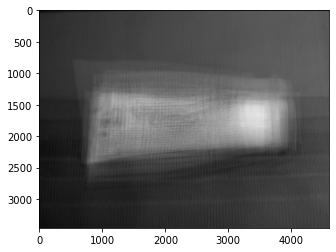

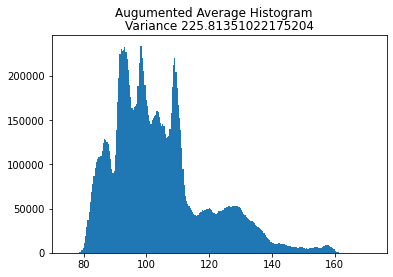




[9] vasos 



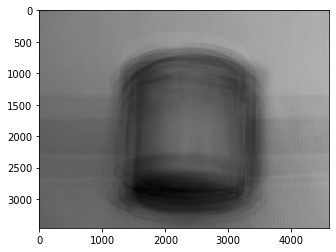

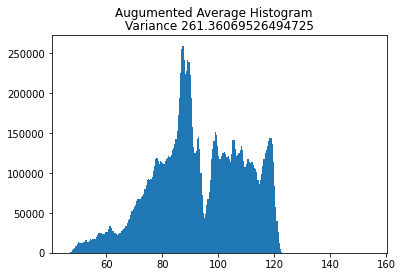

In [ ]:
# SHOW/SAVE AUGMENTED AVERAGES
VERBOSE = True
for idx, img_class in enumerate(classes):
    io.imsave(f'{root}/averagePrototypes/augmentedDataSet/{img_class}_augmented_avg.png', augmented_avg[idx].astype(np.uint8))
    if VERBOSE:
        print(f'[{idx}] {img_class} \n')
        plt.imshow(augmented_avg[idx].astype(np.uint8), cmap='gray')
        plt.show()
        plt.close()

    histogram = augmented_avg[idx].ravel()
    variance = np.var(histogram)
    plt.suptitle(f"Augumented Average Histogram")
    plt.title(f"Variance {variance}")
    plt.hist(histogram, bins = 256)
    plt.savefig(f'{root}/averagePrototypes/augmentedDataSet/{img_class}_augmented_avg_hist.png', dpi=300)
    if VERBOSE:
        plt.show()
        print('\n\n')
    plt.close()

[0] borrachas 



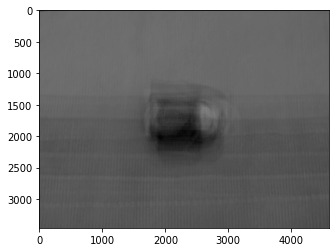

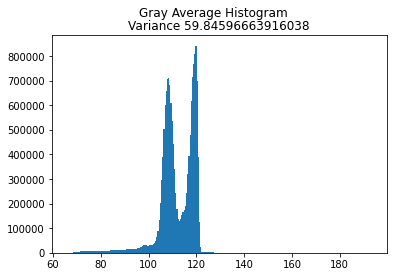




[1] cartas 



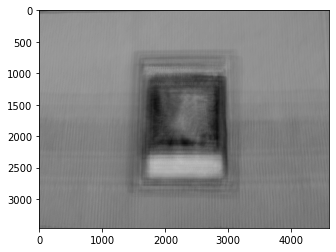

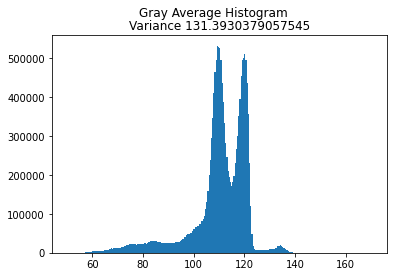




[2] celulares 



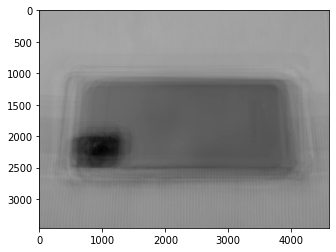

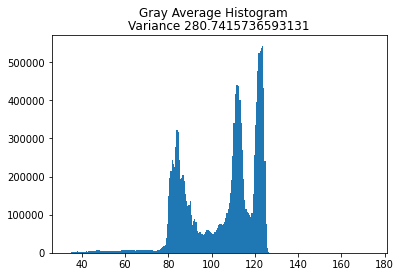




[3] conchas 



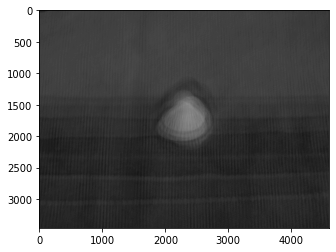

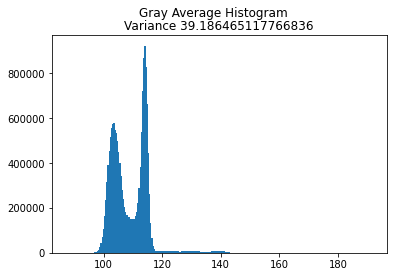




[4] copos 



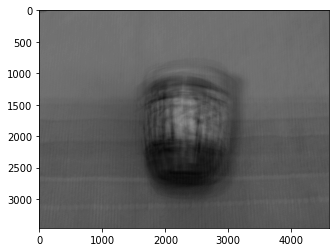

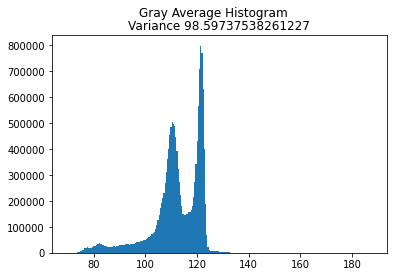




[5] dados 



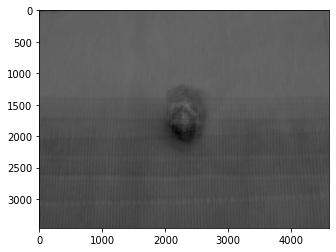

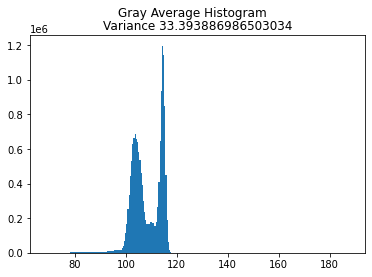




[6] estatuas 



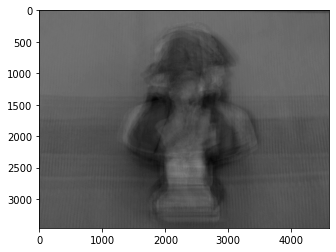

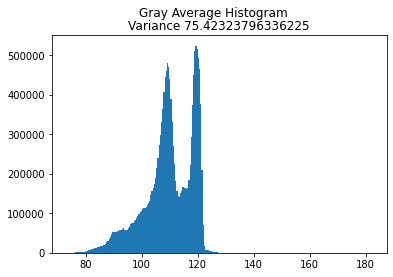




[7] lapis 



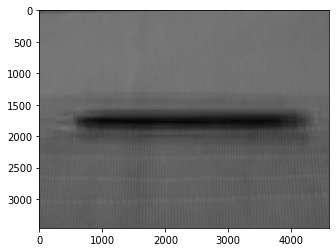

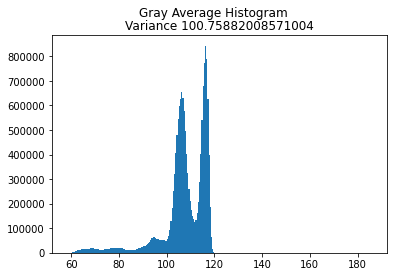




[8] tubos 



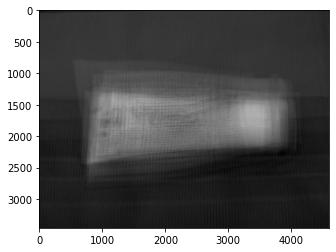

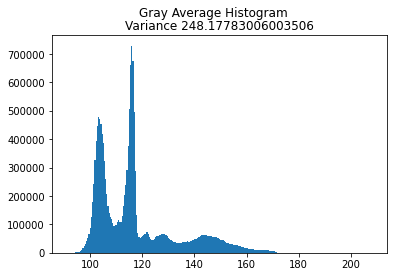




[9] vasos 



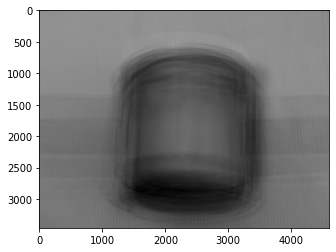

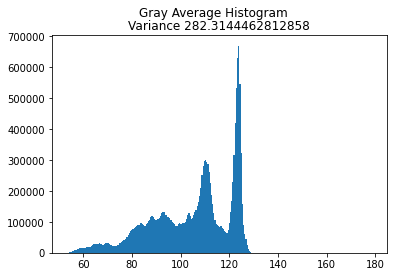

In [ ]:
# SHOW/SAVE AUGMENTED AVERAGES
VERBOSE = True
for idx, img_class in enumerate(classes):
    io.imsave(f'{root}/averagePrototypes/originalGreyDataSet/{img_class}_gray_avg.png', gray_avg[idx].astype(np.uint8))
    if VERBOSE:
        print(f'[{idx}] {img_class} \n')
        plt.imshow(gray_avg[idx].astype(np.uint8), cmap='gray')
        plt.show()
        plt.close()

    histogram = gray_avg[idx].ravel()
    variance = np.var(histogram)
    plt.suptitle(f"Gray Average Histogram")
    plt.title(f"Variance {variance}")
    plt.hist(histogram, bins = 256)
    plt.savefig(f'{root}/averagePrototypes/originalGreyDataSet/{img_class}_gray_avg_hist.png', dpi=300)
    if VERBOSE:
        plt.show()
        print('\n\n')
    plt.close()

[0] borrachas 



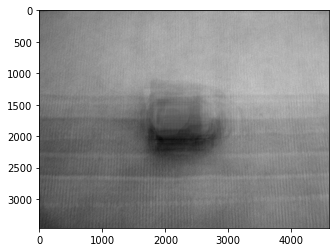

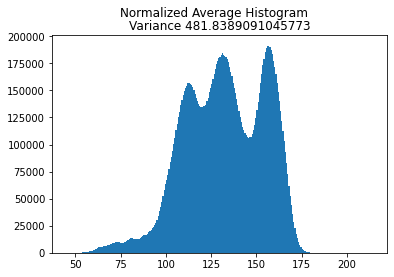




[1] cartas 



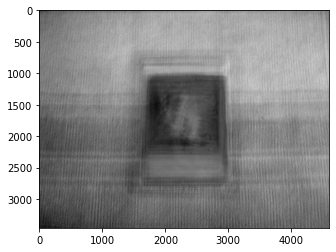

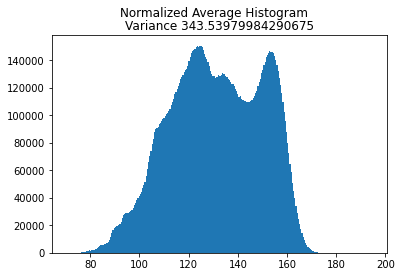




[2] celulares 



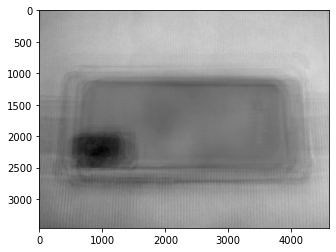

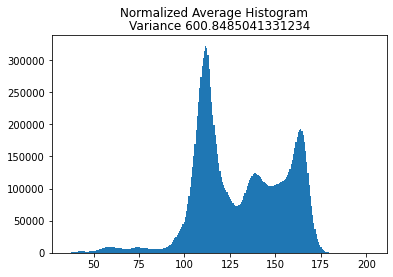




[3] conchas 



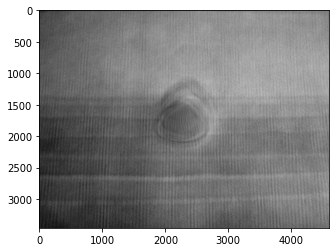

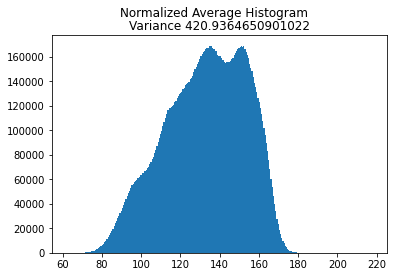




[4] copos 



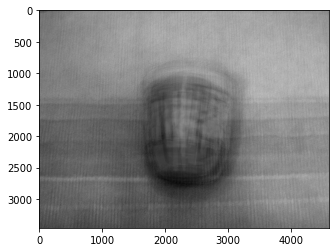

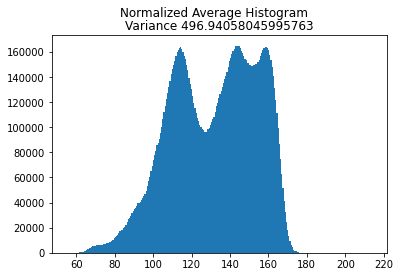




[5] dados 



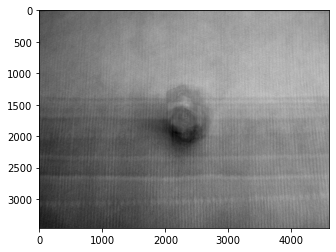

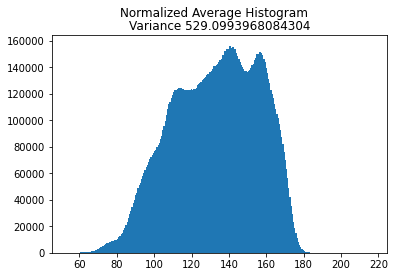




[6] estatuas 



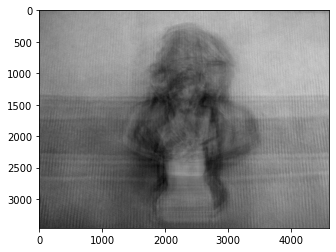

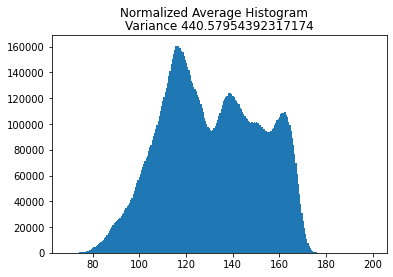




[7] lapis 



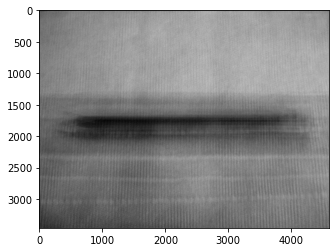

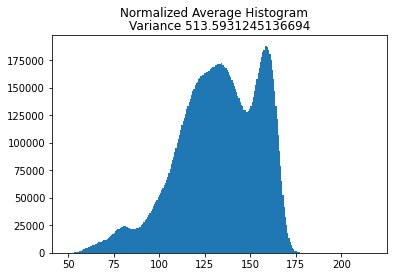




[8] tubos 



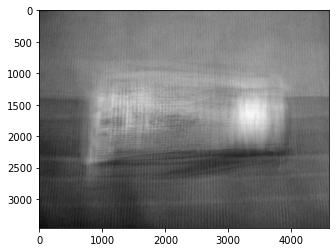

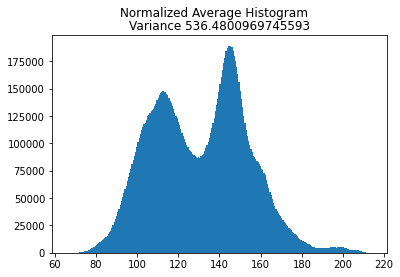




[9] vasos 



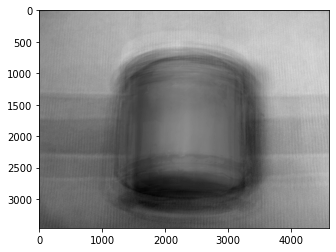

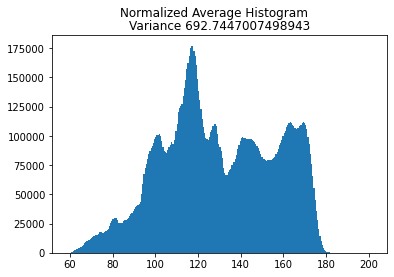

In [ ]:
# SHOW/SAVE AUGMENTED AVERAGES
VERBOSE = True
for idx, img_class in enumerate(classes):
    io.imsave(f'{root}/averagePrototypes/normalizedDataSet/{img_class}_normalized_avg.png', normalized_avg[idx].astype(np.uint8))
    if VERBOSE:
        print(f'[{idx}] {img_class} \n')
        plt.imshow(normalized_avg[idx].astype(np.uint8), cmap='gray')
        plt.show()
        plt.close()

    histogram = normalized_avg[idx].ravel()
    variance = np.var(histogram)
    plt.suptitle(f"Normalized Average Histogram")
    plt.title(f"Variance {variance}")
    plt.hist(histogram, bins = 256)
    plt.savefig(f'{root}/averagePrototypes/normalizedDataSet/{img_class}_normalized_avg_hist.png', dpi=300)
    if VERBOSE:
        plt.show()
        print('\n\n')
    plt.close()